In [ ]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt1
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import tqdm
import numpy as np
from keras import callbacks

In [ ]:
!unzip /kaggle/input/carvana-image-masking-challenge/train_masks.zip -d train_mask

Archive:  /kaggle/input/carvana-image-masking-challenge/train_masks.zip
   creating: train_mask/train_masks/
  inflating: train_mask/train_masks/00087a6bd4dc_01_mask.gif  
 extracting: train_mask/train_masks/00087a6bd4dc_02_mask.gif  
 extracting: train_mask/train_masks/00087a6bd4dc_03_mask.gif  
 extracting: train_mask/train_masks/00087a6bd4dc_04_mask.gif  
  inflating: train_mask/train_masks/00087a6bd4dc_05_mask.gif  
  inflating: train_mask/train_masks/00087a6bd4dc_06_mask.gif  
  inflating: train_mask/train_masks/00087a6bd4dc_07_mask.gif  
  inflating: train_mask/train_masks/00087a6bd4dc_08_mask.gif  
  inflating: train_mask/train_masks/00087a6bd4dc_09_mask.gif  
  inflating: train_mask/train_masks/00087a6bd4dc_10_mask.gif  
 extracting: train_mask/train_masks/00087a6bd4dc_11_mask.gif  
  inflating: train_mask/train_masks/00087a6bd4dc_12_mask.gif  
  inflating: train_mask/train_masks/00087a6bd4dc_13_mask.gif  
  inflating: train_mask/train_masks/00087a6bd4dc_14_mask.gif  
 extracti

In [ ]:
os.mkdir('/kaggle/working/input_mask')

In [ ]:
input_path = '/kaggle/working/train_mask/train_masks/'
output_path = '/kaggle/working/input_mask/'

In [ ]:
for img in tqdm.tqdm(os.listdir(input_path)):
    name = img[:-9]
    image = Image.open(input_path+img).convert('RGB')
    image.save(f'{output_path}{name}.jpg')

100%|██████████| 5088/5088 [04:27<00:00, 19.01it/s]


In [ ]:
input_image_path = '/kaggle/working/train_images/train/'
input_mask_path = '/kaggle/working/input_mask/'

In [ ]:
len(os.listdir(input_mask_path))

5088

In [ ]:
# create empty lists to store the input and output images
X = []
Y = []

# loop through the input images in the directory
for input_image in tqdm.tqdm(os.listdir(input_image_path)):
    # read the input image using cv2
    img = cv2.resize(cv2.imread(os.path.join(input_image_path, input_image)), (224,224), cv2.INTER_CUBIC)
    # append the input image to the x list
    X.append(np.array(img))

    # read the corresponding output image using cv2
    img = cv2.resize(cv2.imread(os.path.join(input_mask_path, input_image)), (224,224), cv2.INTER_CUBIC)
    # append the output image to the y list
    Y.append(np.array(img))


100%|██████████| 5088/5088 [03:34<00:00, 23.68it/s]


In [ ]:
X = np.array(X)
Y = np.array(Y)

In [ ]:
X.shape

(5088, 224, 224, 3)

In [ ]:
Y.shape

(5088, 224, 224, 3)

In [ ]:
# U-Net Xception style model
image_size = (224,224,3)
inputs = keras.Input(shape = image_size)

# entry block
x = layers.Conv2D(32,3,strides = 2,padding = 'same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
previous_block_activation = x  # sed aside residual

# blocks 1,2,3 are identical apart from the feature depth
for filters in [64,128,256]:
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters, 3, padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(filters, 3, padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.MaxPooling2D(3, strides= 2, padding = 'same')(x)
    
    # project residual 
    residual = layers.Conv2D(filters, 1, strides = 2, padding = 'same')(previous_block_activation)
    x = layers.add([x,residual])  # add block residual
    previous_block_activation = x  # set aside next residual
    
# second half of the network : upsampling inputs
for filters in [256,128,64,32]:
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters, 3, padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(filters, 3, padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.UpSampling2D(2)(x)
    
    # project residual 
    residual = layers.UpSampling2D(2)(previous_block_activation)
    residual = layers.Conv2D(filters, 1, padding='same')(residual)
    x = layers.add([x,residual])   # add back residuals
    previous_block_activation = x   # set aside next residual
    
# output layers 
outputs = layers.Conv2D(3,3, activation= 'relu', padding = 'same')(x)

# define the model
model = keras.Model(inputs, outputs)
# free up ram in case the model definition cells were run multiple times
keras.backend.clear_session()


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
model.compile(
    loss = tf.keras.losses.mean_squared_error,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [ ]:
# early stopping 
early_stopping = callbacks.EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0.001, # minimum amount of change to count as an improvement 
    patience = 7, # how many epochs to wait before stopping 
    restore_best_weights = True
)

In [ ]:
model.fit(X,Y,batch_size = 32, epochs = 100,verbose = 1, callbacks =[early_stopping], validation_split = 0.2)

Epoch 1/100


2023-01-27 12:21:48.598938: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


128/128 [==============================] - 67s 422ms/step - loss: 1472.7977 - accuracy: 0.8106 - val_loss: 13601.9365 - val_accuracy: 1.0000
Epoch 2/100
128/128 [==============================] - 53s 411ms/step - loss: 549.6786 - accuracy: 0.8300 - val_loss: 13601.9365 - val_accuracy: 1.0000
Epoch 3/100
128/128 [==============================] - 54s 419ms/step - loss: 415.3887 - accuracy: 0.8348 - val_loss: 13601.9365 - val_accuracy: 1.0000
Epoch 4/100
128/128 [==============================] - 53s 416ms/step - loss: 366.9096 - accuracy: 0.8375 - val_loss: 10047.0996 - val_accuracy: 0.9117
Epoch 5/100
128/128 [==============================] - 53s 416ms/step - loss: 327.8139 - accuracy: 0.8404 - val_loss: 515.1222 - val_accuracy: 0.8231
Epoch 6/100
128/128 [==============================] - 53s 418ms/step - loss: 300.5868 - accuracy: 0.8407 - val_loss: 347.2345 - val_accuracy: 0.8373
Epoch 7/100
128/128 [==============================] - 53s 416ms/step - loss: 272.5725 - accuracy: 0.84

In [ ]:
!unzip /kaggle/input/carvana-image-masking-challenge/test.zip -d test

Archive:  /kaggle/input/carvana-image-masking-challenge/test.zip
   creating: test/test/
  inflating: test/test/0004d4463b50_01.jpg  
  inflating: test/test/0004d4463b50_02.jpg  
  inflating: test/test/0004d4463b50_03.jpg  
  inflating: test/test/0004d4463b50_04.jpg  
  inflating: test/test/0004d4463b50_05.jpg  
  inflating: test/test/0004d4463b50_06.jpg  
  inflating: test/test/0004d4463b50_07.jpg  
  inflating: test/test/0004d4463b50_08.jpg  
  inflating: test/test/0004d4463b50_09.jpg  
  inflating: test/test/0004d4463b50_10.jpg  
  inflating: test/test/0004d4463b50_11.jpg  
  inflating: test/test/0004d4463b50_12.jpg  
  inflating: test/test/0004d4463b50_13.jpg  
  inflating: test/test/0004d4463b50_14.jpg  
  inflating: test/test/0004d4463b50_15.jpg  
  inflating: test/test/0004d4463b50_16.jpg  
  inflating: test/test/000aa097d423_01.jpg  
  inflating: test/test/000aa097d423_02.jpg  
  inflating: test/test/000aa097d423_03.jpg  
  inflating: test/test/000aa097d423_04.jpg  
  inflating

In [ ]:
import random
import matplotlib.pyplot as plt

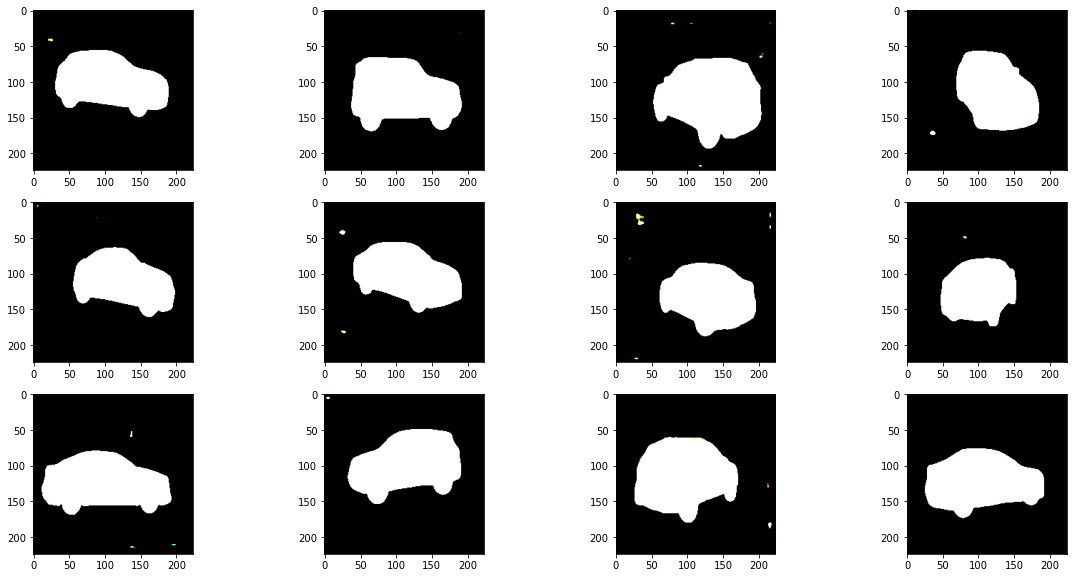

In [ ]:
plt.figure(figsize=(20,10))
path = '/kaggle/working/test/test/'
images = os.listdir(path)
i = 1
while i <= 12:
    img = random.choice(images)
    img = cv2.resize(cv2.imread(os.path.join(path, img)), (224,224), cv2.INTER_CUBIC)
    img = np.expand_dims(img, axis=0)
    out = model.predict(img)
    ax = plt.subplot(3,4,i)  #(nrows, ncolumns, index)
    plt.imshow(out[0], cmap = 'gray')
    i += 1